In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import yfinance as yf
sys.path.append("../")
import numpy as np
import numpy.linalg as LA
from estimators.N_estimators import sample_mean_and_cov, GFA_EM_simple
from estimators.Tyler_estimators import TRex_simple
from estimators.T_estimators import TFA_ECME
from estimators.STE import STE
from experiments.utils import generate_samples, scatter_to_corr, build_true_cov, errors_corr
np.random.seed(0)

In [4]:
# download data
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK-B', 'NVDA', 'META', 'TSLA', 
    'UNH', 'XOM', 'JNJ', 'V', 'PG', 'JPM', 'MA', 'LLY', 'HD', 'MRK',
    'AVGO', 'PEP', 'KO', 'CVX', 'ABBV', 'PFE', 'COST', 'MCD', 'TMO',
    'WMT', 'NFLX', 'DIS', 'ABT', 'CSCO', 'VZ', 'ACN', 'DHR', 'ADBE', 
    'NEE', 'NKE', 'CRM', 'TXN', 'QCOM', 'INTC', 'LIN', 'AMGN', 'MDT',
    'PM', 'HON', 'MS', 'AMT', 'BA'
]
data = yf.download(tickers, start="2023-01-01", end="2024-01-01")['Close']
data.dropna(inplace=True)
returns = data.pct_change().dropna().values.T
S_true = sample_mean_and_cov(returns)[1]

# compute "true" covariance matrix
rank = 5
cov_true = build_true_cov(returns, rank)
corr_true = scatter_to_corr([cov_true])[0]
n = cov_true.shape[0]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  50 of 50 completed


In [5]:
# settings for experiment
num_runs, all_m = 100, [100, 150, 200, 250, 300]
errors_Gaussian_data_no_outliers_GFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_no_outliers_TRex = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_no_outliers_TFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_no_outliers_STE = np.zeros((num_runs, len(all_m)))

errors_Gaussian_data_outliers_GFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_outliers_TRex = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_outliers_TFA = np.zeros((num_runs, len(all_m)))
errors_Gaussian_data_outliers_STE = np.zeros((num_runs, len(all_m)))

errors_multiT_data_no_outliers_GFA = np.zeros((num_runs, len(all_m)))
errors_multiT_data_no_outliers_TRex = np.zeros((num_runs, len(all_m)))
errors_multiT_data_no_outliers_TFA = np.zeros((num_runs, len(all_m)))
errors_multiT_data_no_outliers_STE = np.zeros((num_runs, len(all_m)))

degrees_of_freedom = 3
noise_factor = 3
percentage_outliers = 0.02

In [ ]:
for distribution in ['N', 'T']:
    for outliers in [False, True]:
        if distribution == "T" and outliers == True:
            continue
        for i in range(len(all_m)):
            m = all_m[i]
            for run in range(num_runs):
                print("m / run: ", m, run)
                if distribution == "N":
                    X = generate_samples(m, "N", {'mu': np.zeros((n, )), 'cov': cov_true})
                else:
                    X = generate_samples(m, "T", {'mu': np.zeros((n, )), 'cov': cov_true, 'v': degrees_of_freedom})

                if outliers:
                    num_of_outliers = int(percentage_outliers*m)
                    mu_outliers = np.ones((n,))
                    mu_outliers[int(n/2):] *= -1
                    mu_outliers /= LA.norm(mu_outliers)
                    mu_outliers *= noise_factor*np.sqrt(np.trace(cov_true))
                
                    outliers_X = generate_samples(num_of_outliers, 'N', {'mu': mu_outliers, 'cov': cov_true})
                    if num_of_outliers == 1:
                        outliers_X = outliers_X.reshape(-1, 1)
                    X = np.hstack([X, outliers_X])

                X = X - np.mean(X, axis=1, keepdims=True)

                
                # compute factor model via Gaussian EM
                S_EM = sample_mean_and_cov(X)[1]
                F_GFA, d_GFA = GFA_EM_simple(S_EM, rank, F=None, d=None, max_iter=200)

                 # compute factor model via T
                F_T, d_T = TFA_ECME(X, rank)

                # compute factor model via TRex 
                F_TRex, d_TRex, stats_TRex = TRex_simple(X, rank, outer_max_iter=20,
                                                         inner_max_iter=200, 
                                                         eps_rel_obj=1e-6)

                # apply subspace constrained Tyler
                scatter_STE, _ = STE(X, rank, 0.95)

                scatter_G_EM = F_GFA @ F_GFA.T + np.diag(d_GFA)
                scatter_TRex = F_TRex @ F_TRex.T + np.diag(d_TRex)
                scatter_T_ECME = F_T @ F_T.T + np.diag(d_T)
                   
                errors = errors_corr([scatter_G_EM, scatter_TRex, 
                                      scatter_T_ECME, scatter_STE],
                                      true_corr=corr_true)

                if distribution == "N" and not outliers:
                    errors_Gaussian_data_no_outliers_GFA[run, i] = errors[0]
                    errors_Gaussian_data_no_outliers_TRex[run, i] = errors[1]
                    errors_Gaussian_data_no_outliers_TFA[run, i] = errors[2]
                    errors_Gaussian_data_no_outliers_STE[run, i] = errors[3]
                elif distribution == "N" and outliers:
                    errors_Gaussian_data_outliers_GFA[run, i] = errors[0]
                    errors_Gaussian_data_outliers_TRex[run, i] = errors[1]
                    errors_Gaussian_data_outliers_TFA[run, i] = errors[2]
                    errors_Gaussian_data_outliers_STE[run, i] = errors[3]
                else:
                    errors_multiT_data_no_outliers_GFA[run, i] = errors[0]
                    errors_multiT_data_no_outliers_TRex[run, i] = errors[1]
                    errors_multiT_data_no_outliers_TFA[run, i] = errors[2]
                    errors_multiT_data_no_outliers_STE[run, i] = errors[3]

m / run:  100 0
m / run:  100 1
m / run:  100 2
m / run:  100 3
m / run:  100 4
m / run:  100 5
m / run:  100 6
m / run:  100 7
m / run:  100 8
m / run:  100 9
m / run:  100 10
m / run:  100 11
m / run:  100 12
m / run:  100 13
m / run:  100 14
m / run:  100 15
m / run:  100 16


Exception ignored from cffi callback <function _processevents at 0x749d72fca020>:
Traceback (most recent call last):
  File "/home/daniel/Documents/Research/code_paper_repos/T-Rex/T-Rex-final-repo-IEEE/T-Rex-EM/venv/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


m / run:  100 17
m / run:  100 18


In [5]:
MSE_errors_Gaussian_data_no_outliers_GFA = np.mean(errors_Gaussian_data_no_outliers_GFA, axis=0)
MSE_errors_Gaussian_data_no_outliers_TRex = np.mean(errors_Gaussian_data_no_outliers_TRex, axis=0)
MSE_errors_Gaussian_data_no_outliers_TFA = np.mean(errors_Gaussian_data_no_outliers_TFA, axis=0)
MSE_errors_Gaussian_data_no_outliers_STE = np.mean(errors_Gaussian_data_no_outliers_STE, axis=0)
STD_errors_Gaussian_data_no_outliers_GFA = np.std(errors_Gaussian_data_no_outliers_GFA, axis=0)
STD_errors_Gaussian_data_no_outliers_TRex = np.std(errors_Gaussian_data_no_outliers_TRex, axis=0)
STD_errors_Gaussian_data_no_outliers_TFA = np.std(errors_Gaussian_data_no_outliers_TFA, axis=0)
STD_errors_Gaussian_data_no_outliers_STE = np.std(errors_Gaussian_data_no_outliers_STE, axis=0)

MSE_errors_Gaussian_data_outliers_GFA = np.mean(errors_Gaussian_data_outliers_GFA, axis=0)
MSE_errors_Gaussian_data_outliers_TRex = np.mean(errors_Gaussian_data_outliers_TRex, axis=0)
MSE_errors_Gaussian_data_outliers_TFA = np.mean(errors_Gaussian_data_outliers_TFA, axis=0)
MSE_errors_Gaussian_data_outliers_STE = np.mean(errors_Gaussian_data_outliers_STE, axis=0)
STD_errors_Gaussian_data_outliers_GFA = np.std(errors_Gaussian_data_outliers_GFA, axis=0)
STD_errors_Gaussian_data_outliers_TRex = np.std(errors_Gaussian_data_outliers_TRex, axis=0)
STD_errors_Gaussian_data_outliers_TFA = np.std(errors_Gaussian_data_outliers_TFA, axis=0)
STD_errors_Gaussian_data_outliers_STE = np.std(errors_Gaussian_data_outliers_STE, axis=0)

MSE_errors_multiT_data_no_outliers_GFA = np.mean(errors_multiT_data_no_outliers_GFA, axis=0)
MSE_errors_multiT_data_no_outliers_TRex = np.mean(errors_multiT_data_no_outliers_TRex, axis=0)
MSE_errors_multiT_data_no_outliers_TFA = np.mean(errors_multiT_data_no_outliers_TFA, axis=0)
MSE_errors_multiT_data_no_outliers_STE = np.mean(errors_multiT_data_no_outliers_STE, axis=0)
STD_errors_multiT_data_no_outliers_GFA = np.std(errors_multiT_data_no_outliers_GFA, axis=0)
STD_errors_multiT_data_no_outliers_TRex = np.std(errors_multiT_data_no_outliers_TRex, axis=0)
STD_errors_multiT_data_no_outliers_TFA = np.std(errors_multiT_data_no_outliers_TFA, axis=0)
STD_errors_multiT_data_no_outliers_STE = np.std(errors_multiT_data_no_outliers_STE, axis=0)


Gaussian relative MSE TFA:  1.195936899961757
Gaussian relative MSE T-Rex:  1.0228780751659903
Gaussian relative MSE STE:  2.0745750919395918


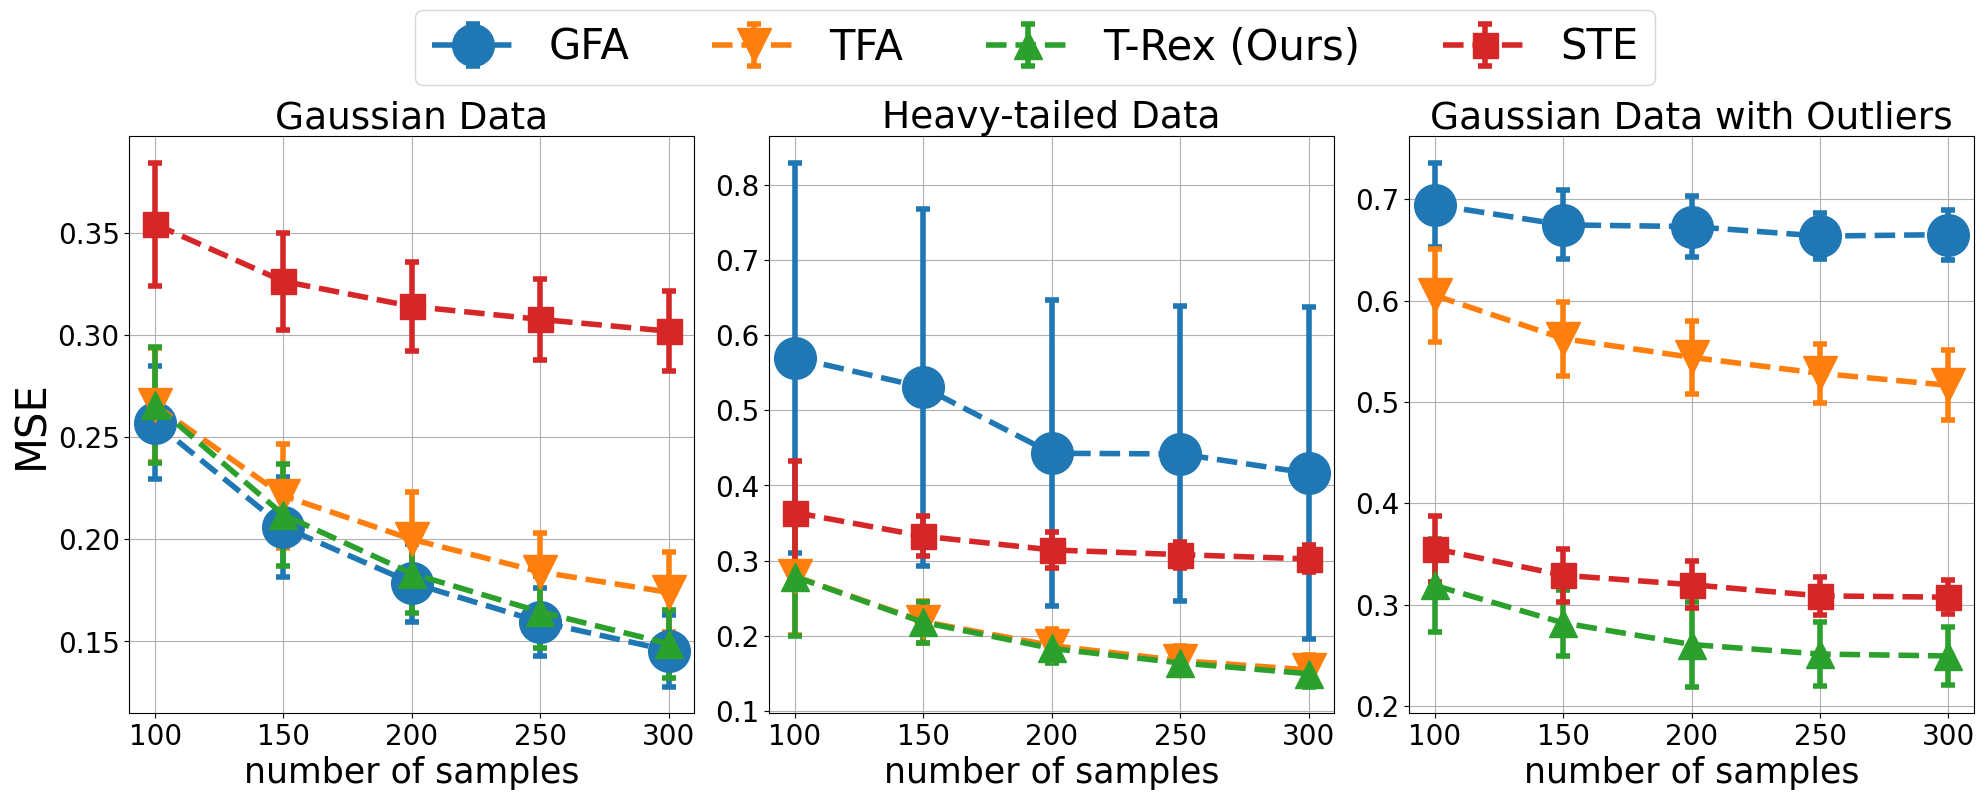

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
MARKERSIZE, CAPSIZE, CAPTHICK, ELINEWIDTH, LINEWIDTH = 12, 5, 4, 4, 4
FONTSIZE_Y, FONTSIZE_X = 30, 25

markersizes = [35, 30, 25, 18, 20]
axs[0].errorbar(all_m, MSE_errors_Gaussian_data_no_outliers_GFA, 
                yerr=STD_errors_Gaussian_data_no_outliers_GFA, 
                marker='o', linestyle='--',  linewidth=LINEWIDTH,
                markersize=30, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH, label="GFA")

axs[0].errorbar(all_m, MSE_errors_Gaussian_data_no_outliers_TFA, 
                yerr=STD_errors_Gaussian_data_no_outliers_TFA, 
                marker='v', linestyle='--',  linewidth=LINEWIDTH,
                markersize=25, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH, label="TFA")


axs[0].errorbar(all_m, MSE_errors_Gaussian_data_no_outliers_TRex, 
                yerr=STD_errors_Gaussian_data_no_outliers_TRex, 
                marker='^', linestyle='--',  linewidth=LINEWIDTH,
                markersize=20, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH, label="T-Rex (Ours)")

axs[0].errorbar(all_m, MSE_errors_Gaussian_data_no_outliers_STE,
                yerr=STD_errors_Gaussian_data_no_outliers_STE, 
                marker='s', linestyle='--',  linewidth=LINEWIDTH,
                markersize=18, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH, label="STE")


axs[1].errorbar(all_m, MSE_errors_multiT_data_no_outliers_GFA, 
                yerr=STD_errors_multiT_data_no_outliers_GFA, 
                marker='o', linestyle='--',  linewidth=LINEWIDTH,
                markersize=30, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[1].errorbar(all_m, MSE_errors_multiT_data_no_outliers_TFA, 
                yerr=STD_errors_multiT_data_no_outliers_TFA, 
                marker='v', linestyle='--',  linewidth=LINEWIDTH,
                markersize=25, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)


axs[1].errorbar(all_m, MSE_errors_multiT_data_no_outliers_TRex, 
                yerr=STD_errors_multiT_data_no_outliers_TRex, 
                marker='^', linestyle='--',  linewidth=LINEWIDTH,
                markersize=20, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[1].errorbar(all_m, MSE_errors_multiT_data_no_outliers_STE,
                yerr=STD_errors_multiT_data_no_outliers_STE, 
                marker='s', linestyle='--',  linewidth=LINEWIDTH,
                markersize=18, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)


axs[2].errorbar(all_m, MSE_errors_Gaussian_data_outliers_GFA, 
                yerr=STD_errors_Gaussian_data_outliers_GFA, 
                marker='o', linestyle='--',  linewidth=LINEWIDTH,
                markersize=30, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[2].errorbar(all_m, MSE_errors_Gaussian_data_outliers_TFA, 
                yerr=STD_errors_Gaussian_data_outliers_TFA, 
                marker='v', linestyle='--',  linewidth=LINEWIDTH,
                markersize=25, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)


axs[2].errorbar(all_m, MSE_errors_Gaussian_data_outliers_TRex, 
                yerr=STD_errors_Gaussian_data_outliers_TRex, 
                marker='^', linestyle='--',  linewidth=LINEWIDTH,
                markersize=20, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[2].errorbar(all_m, MSE_errors_Gaussian_data_outliers_STE,
                yerr=STD_errors_Gaussian_data_outliers_STE, 
                marker='s', linestyle='--',  linewidth=LINEWIDTH,
                markersize=18, capsize=CAPSIZE, capthick=CAPTHICK, 
                elinewidth=ELINEWIDTH)

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=20)

axs[0].set_ylabel('MSE', fontsize=FONTSIZE_Y)
axs[0].set_xlabel('number of samples', fontsize=FONTSIZE_X)
axs[1].set_xlabel('number of samples', fontsize=FONTSIZE_X)
axs[2].set_xlabel('number of samples', fontsize=FONTSIZE_X)
axs[0].set_title('Gaussian Data', fontsize=27)
axs[1].set_title('Heavy-tailed Data', fontsize=27)
axs[2].set_title('Gaussian Data with Outliers', fontsize=27)
plt.tight_layout(rect=[0, 0, 1, 0.90])
fig.legend(fontsize=30, loc='upper center', bbox_to_anchor=(0.52, 1.02), ncol=4)
plt.savefig("figures/MSE_vs_samples.pdf")


print("Gaussian relative MSE TFA: ", MSE_errors_Gaussian_data_no_outliers_TFA[-1] / MSE_errors_Gaussian_data_no_outliers_GFA[-1])
print("Gaussian relative MSE T-Rex: ", MSE_errors_Gaussian_data_no_outliers_TRex[-1] / MSE_errors_Gaussian_data_no_outliers_GFA[-1])
print("Gaussian relative MSE STE: ", MSE_errors_Gaussian_data_no_outliers_STE[-1] / MSE_errors_Gaussian_data_no_outliers_GFA[-1])
